In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from datetime import datetime

In [87]:
import matplotlib.dates as mdates
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Arial'

In [2]:
MEL_14DAY_AVG_VALUE = '34'


PROJECT_ID = '<<INSERT PROJECT ID>>'

In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
from google.cloud import bigquery

client = bigquery.Client(project=PROJECT_ID)


## New case details

Query was adapted from prior analysis - much of this data is not used in this notebook


In [5]:
df_eu = client.query(f""" 

WITH
new_case_counts AS (

-- Australia (include Melbourne 2nd wave)
SELECT 
date,
country_name,
subregion1_name || ', ' || country_name as province_name,
new_confirmed as new_cases
FROM 
`bigquery-public-data.covid19_open_data.covid19_open_data` 
WHERE
  country_name = 'Australia'
  
-- New Zealand (Auckland)
UNION ALL 

SELECT 
date,
country_name,
country_name as province_name,
SUM(new_confirmed) as new_cases
FROM 
`bigquery-public-data.covid19_open_data.covid19_open_data` 
WHERE
  country_name = 'New Zealand'
GROUP BY 1, 2, 3),

-- Apply moving average smoothing (14-day average)

new_cases_smooth AS (
SELECT
*,
AVG(new_cases) OVER (PARTITION BY province_name ORDER BY date ROWS BETWEEN 13 PRECEDING AND CURRENT ROW) as new_cases_moving_avg
FROM new_case_counts
WHERE new_cases IS NOT NULL),

-- Find indication whether over intial peak
max_cases_smooth_date AS (SELECT * FROM (
SELECT 
province_name,
date,
new_cases_moving_avg,
ROW_NUMBER() OVER (PARTITION BY province_name ORDER BY new_cases_moving_avg DESC) as rn
FROM new_cases_smooth
) t WHERE t.rn = 1),

new_cases_smooth_peak_ind AS (
SELECT 
A.*,
B.date as peak_new_cases_date,
B.new_cases_moving_avg as peak_new_cases_moving_avg,
CASE WHEN A.date > B.date THEN 1 ELSE 0 END as after_peak_flag
FROM new_cases_smooth A 
LEFT JOIN max_cases_smooth_date B 
  ON A.province_name = B.province_name),

-- Find days with similar 14-day average and on a post-peak trend
equiv_14day_average AS (SELECT * FROM (
SELECT 
province_name,
date,
ROW_NUMBER() OVER (PARTITION BY province_name ORDER BY ABS(new_cases_moving_avg - 36)) as rn
FROM new_cases_smooth_peak_ind
WHERE after_peak_flag = 1
) t WHERE t.rn = 1),

new_cases_14day_avg_shifted AS (
SELECT 
A.*,
B.date as equiv_14day_average_date,
DATE_DIFF(A.date, B.date, DAY) as days_from_equiv_14day_avg_val
FROM new_cases_smooth_peak_ind A 
LEFT JOIN equiv_14day_average B 
  ON A.province_name = B.province_name)
  
 SELECT 
date,
country_name,
province_name,
new_cases,
new_cases_moving_avg,
peak_new_cases_date,
peak_new_cases_moving_avg,
after_peak_flag,
equiv_14day_average_date,
days_from_equiv_14day_avg_val
FROM new_cases_14day_avg_shifted
ORDER BY province_name, date






""").to_dataframe()
df_eu['date'] = pd.to_datetime(df_eu['date'])
df_eu['peak_new_cases_date'] = pd.to_datetime(df_eu['peak_new_cases_date'])

In [6]:
df_eu.to_csv('df_au_nz_new_cases.csv', index=False)

In [132]:
## NSW data for July 3 appears to be anomalous
## Will use values from NSW health directly to also exclude overseas arrivals
df_eu[(df_eu['province_name'] == 'New South Wales, Australia') & (df_eu['date'] >= '2020-07-01')].sort_values('new_cases', ascending=False)

,date,country_name,province_name,new_cases,new_cases_moving_avg,peak_new_cases_date,peak_new_cases_moving_avg,after_peak_flag,equiv_14day_average_date,days_from_equiv_14day_avg_val
635,2020-07-03,Australia,"New South Wales, Australia",189,18.357143,2020-04-04,147.0,1,2020-04-17,77.0
674,2020-08-11,Australia,"New South Wales, Australia",22,14.142857,2020-04-04,147.0,1,2020-04-17,116.0
663,2020-07-31,Australia,"New South Wales, Australia",20,15.785714,2020-04-04,147.0,1,2020-04-17,105.0
652,2020-07-20,Australia,"New South Wales, Australia",20,11.357143,2020-04-04,147.0,1,2020-04-17,94.0
655,2020-07-23,Australia,"New South Wales, Australia",19,12.857143,2020-04-04,147.0,1,2020-04-17,97.0
...,...,...,...,...,...,...,...,...,...,...
720,2020-09-26,Australia,"New South Wales, Australia",1,4.357143,2020-04-04,147.0,1,2020-04-17,162.0
684,2020-08-21,Australia,"New South Wales, Australia",1,9.285714,2020-04-04,147.0,1,2020-04-17,126.0
718,2020-09-24,Australia,"New South Wales, Australia",1,5.071429,2020-04-04,147.0,1,2020-04-17,160.0
721,2020-09-27,Australia,"New South Wales, Australia",0,3.714286,2020-04-04,147.0,1,2020-04-17,163.0


In [8]:
df_eu['province_name'].unique()

array([None, 'Australian Capital Territory, Australia',
       'New South Wales, Australia', 'New Zealand',
       'Northern Territory, Australia', 'Queensland, Australia',
       'South Australia, Australia', 'Tasmania, Australia',
       'Victoria, Australia', 'Western Australia, Australia'],
      dtype=object)

In [9]:
provinces = ['Victoria, Australia', 'New South Wales, Australia', 'New Zealand']

In [133]:
## Data from NSW Health includes breakdown by source of infection
df_nsw = pd.read_csv('https://data.nsw.gov.au/data/dataset/c647a815-5eb7-4df6-8c88-f9c537a4f21e/resource/2f1ba0f3-8c21-4a86-acaf-444be4401a6d/download/confirmed_cases_table3_likely_source.csv')

In [11]:
df_nsw.head()

,notification_date,likely_source_of_infection
0,2020-03-09,Overseas
1,2020-03-09,Locally acquired - contact of a confirmed case...
2,2020-03-09,Overseas
3,2020-03-09,Locally acquired - contact of a confirmed case...
4,2020-03-09,Locally acquired - contact of a confirmed case...


In [13]:
## NSW Healths data appears to have one case per row
df_nsw['num_cases'] = 1
df_nsw['date'] = pd.to_datetime(df_nsw['notification_date'])

In [14]:
df_nsw['likely_source_of_infection'].value_counts()

Overseas                                                                    2135
Locally acquired - contact of a confirmed case and/or in a known cluster    1386
Locally acquired - source not identified                                     391
Interstate                                                                    89
Name: likely_source_of_infection, dtype: int64

In [15]:
df_nsw_counts = df_nsw.groupby(['date', 'likely_source_of_infection']).agg({
    'num_cases': 'sum'
}).reset_index()
df_nsw_counts.head()

,date,likely_source_of_infection,num_cases
0,2020-03-09,Locally acquired - contact of a confirmed case...,7
1,2020-03-09,Locally acquired - source not identified,1
2,2020-03-09,Overseas,5
3,2020-03-10,Locally acquired - contact of a confirmed case...,2
4,2020-03-10,Overseas,4


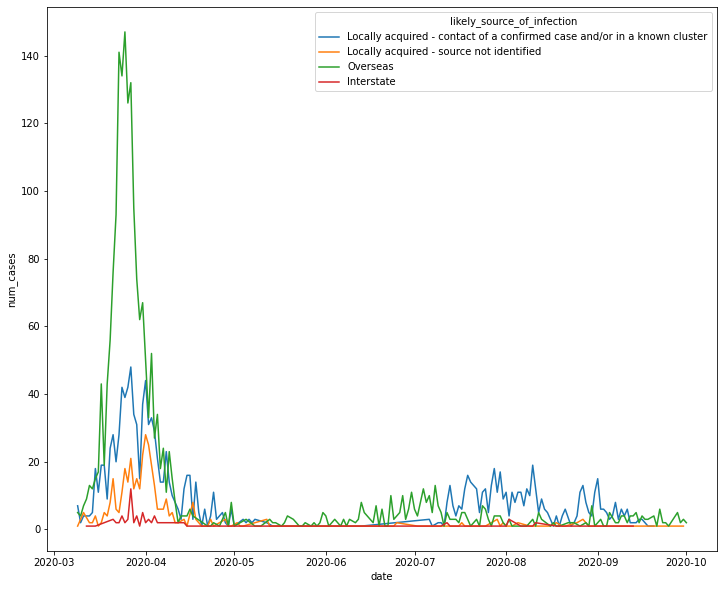

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.lineplot(x='date', y='num_cases', hue='likely_source_of_infection', data=df_nsw_counts)

In [18]:
df_nsw_counts_non_overseas = df_nsw[~df_nsw['likely_source_of_infection'].isin({'Overseas'})].groupby(['date']).agg({
    'num_cases': 'sum'
}).reset_index().rename(columns={'num_cases': 'new_cases'})
df_nsw_counts_non_overseas

,date,new_cases
0,2020-03-09,8
1,2020-03-10,2
2,2020-03-11,9
3,2020-03-12,5
4,2020-03-13,6
...,...,...
141,2020-09-18,1
142,2020-09-19,1
143,2020-09-20,1
144,2020-09-23,1


In [19]:
df_nsw_counts_all = df_nsw.groupby(['date']).agg({
    'num_cases': 'sum'
}).reset_index().rename(columns={'num_cases': 'new_cases'})
df_nsw_counts_all

,date,new_cases
0,2020-03-09,13
1,2020-03-10,6
2,2020-03-11,16
3,2020-03-12,14
4,2020-03-13,19
...,...,...
192,2020-09-25,1
193,2020-09-28,5
194,2020-09-29,2
195,2020-09-30,4


In [134]:
## Compute 14-day moving averages

def get_moving_average(df, cases_col='new_cases', date_col='date', cases_avg_col='new_cases_moving_avg', window_days=14):
  ## Make a contiguous date range
  df_daterange = pd.DataFrame(pd.date_range(start=df[date_col].min(), end=df[date_col].max(), freq='D'), columns=[date_col])
  df_w_dates = pd.merge(df_daterange,
                        df,
                        on=date_col,
                        how='left')
  df_w_dates[cases_col] = df_w_dates[cases_col].fillna(0)
  df_w_dates[cases_avg_col] = df_w_dates[cases_col].rolling(window_days).mean()
  df_w_dates['province_name'] = df_w_dates['province_name'].fillna(df_w_dates['province_name'].unique()[0])
  return df_w_dates

def get_analysis_days(df, peak_date, date_col='date', days_col='day'):
  df['start_date'] = peak_date
  df[days_col] = (df[date_col] - df['start_date']).apply(lambda x: x.days)
  return df

In [21]:
##Analysis day = days since "peak" of interest:
## VIC Wave 2 peak = 2020-08-08
## NSW Wave 2 = Melbourne Wave 2 peak
## NSW Wave 1 peak = 2020-04-05

## NSW restaurants reopened May 15

In [135]:
## Extract data for "Wave 1" and "Wave 2" of COVID-19
df_vic_wave2 = df_eu[df_eu['province_name'] == 'Victoria, Australia'][['province_name', 'date', 'new_cases']]

df_nsw_wave2 = df_nsw_counts_non_overseas[['date', 'new_cases']]
df_nsw_wave2['province_name'] = 'NSW, Australia'

df_nsw_wave1 = df_nsw_wave2.copy()

df_nsw_wave1_all = df_nsw_counts_all[['date', 'new_cases']]
df_nsw_wave1_all['province_name'] = 'NSW, Australia'

In [136]:
## Attach moving average and shift dates to relevant peaks

df_vic_wave2_w_avg = get_moving_average(df_vic_wave2)
df_vic_wave2_w_avg = get_analysis_days(df_vic_wave2_w_avg, datetime(2020, 8, 8))

df_nsw_wave2_w_avg = get_moving_average(df_nsw_wave2)
df_nsw_wave2_w_avg = get_analysis_days(df_nsw_wave2_w_avg, datetime(2020, 8, 8))

df_nsw_wave1_w_avg = get_moving_average(df_nsw_wave1)
df_nsw_wave1_w_avg = get_analysis_days(df_nsw_wave1_w_avg, datetime(2020, 4, 5))
df_nsw_wave1_w_avg['province_name'] = 'NSW - Wave 1 excluding overseas'

df_nsw_wave1_w_avg_all = get_moving_average(df_nsw_wave1_all)
df_nsw_wave1_w_avg_all = get_analysis_days(df_nsw_wave1_w_avg_all, datetime(2020, 4, 5))
df_nsw_wave1_w_avg_all['province_name'] = 'NSW'

In [137]:
## Concatenate the samples
df_data = pd.concat([df_vic_wave2_w_avg, df_nsw_wave2_w_avg, df_nsw_wave1_w_avg, df_nsw_wave1_w_avg_all])

In [138]:
df_data

,date,province_name,new_cases,new_cases_moving_avg,start_date,day
0,2020-01-27,"Victoria, Australia",0.0,NaN,2020-08-08,-194
1,2020-01-28,"Victoria, Australia",0.0,NaN,2020-08-08,-193
2,2020-01-29,"Victoria, Australia",1.0,NaN,2020-08-08,-192
3,2020-01-30,"Victoria, Australia",1.0,NaN,2020-08-08,-191
4,2020-01-31,"Victoria, Australia",0.0,NaN,2020-08-08,-190
...,...,...,...,...,...,...
202,2020-09-27,NSW,0.0,3.214286,2020-04-05,175
203,2020-09-28,NSW,5.0,3.071429,2020-04-05,176
204,2020-09-29,NSW,2.0,2.857143,2020-04-05,177
205,2020-09-30,NSW,4.0,2.642857,2020-04-05,178


Peak values
                                 new_cases_moving_avg
province_name                                        
NSW - Wave 1 excluding overseas             13.071429
Victoria, Australia                        467.071429



                                      date           
                                       min        max
province_name                                        
NSW - Wave 1 excluding overseas 2020-07-18 2020-09-14
Victoria, Australia             2020-06-01 2020-10-01





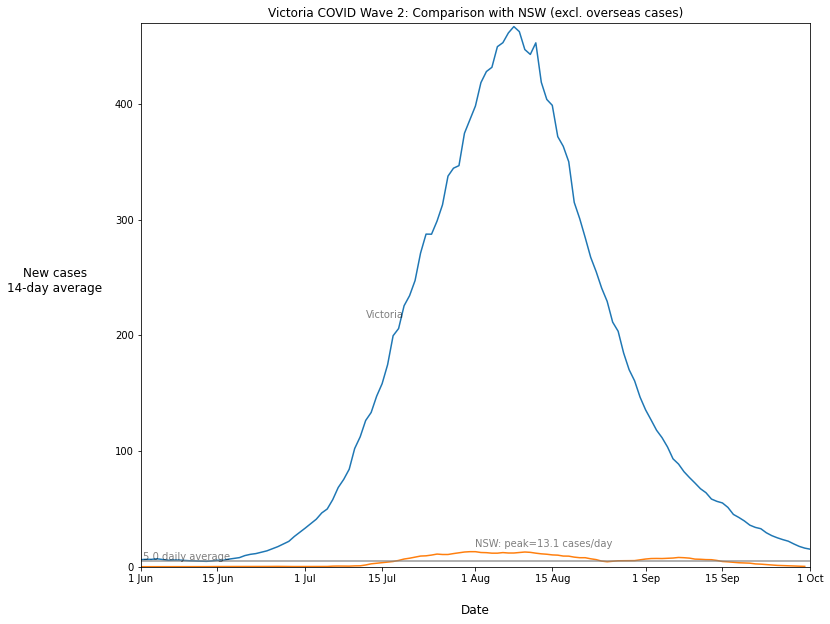

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
df_data_plot = df_data[df_data['province_name'].isin({'Victoria, Australia', 'NSW - Wave 1 excluding overseas'})]

sns.lineplot(x='date', 
             y='new_cases_moving_avg', 
             hue='province_name', 
             data=df_data_plot)

dt_chart_start = datetime(2020, 6, 1)
dt_chart_end = datetime(2020, 10, 1)
xlim_values = (mdates.date2num(dt_chart_start), mdates.date2num(dt_chart_end))
ylim_values = (0, 470)

ax.set_xlim(xlim_values)
ax.set_ylim(ylim_values)
ax.get_legend().remove()
ax.set_ylabel('New cases\n14-day average', rotation=0, fontsize=12, labelpad=60)
ax.set_xlabel('Date', fontsize=12, labelpad=20)
ax.text(mdates.date2num(datetime(2020, 7, 12)), 215, 'Victoria', alpha=0.5)
ax.text(mdates.date2num(datetime(2020, 8, 1)), 17, 'NSW: peak=13.1 cases/day ', alpha=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b'))
ax.set_title('Victoria COVID Wave 2: Comparison with NSW (excl. overseas cases)')
ax.plot(xlim_values, [5.0]*2, color=(0.5, 0.5, 0.5), alpha=0.8)
ax.text(xlim_values[0]+0.5, 6, '5.0 daily average', alpha=0.5)


ax.set_xlim(xlim_values)
ax.set_ylim(ylim_values)


df_data_nsw_thresholds = df_data_plot[(df_data_plot['date'] >= dt_chart_start) & (df_data_plot['date'] <= dt_chart_end)]

print('Peak values')
print(df_data_nsw_thresholds.sort_values('new_cases_moving_avg', ascending=False)\
.groupby('province_name')\
.agg({
    'new_cases_moving_avg': 'max'
}))

print('\n\n')
print(df_data_nsw_thresholds[df_data_nsw_thresholds['new_cases_moving_avg'] > 5].groupby('province_name').agg({
    'date': ['min', 'max']
}))

print('\n\n')
plt.show()


         date                    province_name  new_cases_moving_avg
67 2020-05-15                              NSW              2.714286
67 2020-05-15  NSW - Wave 1 excluding overseas              1.785714





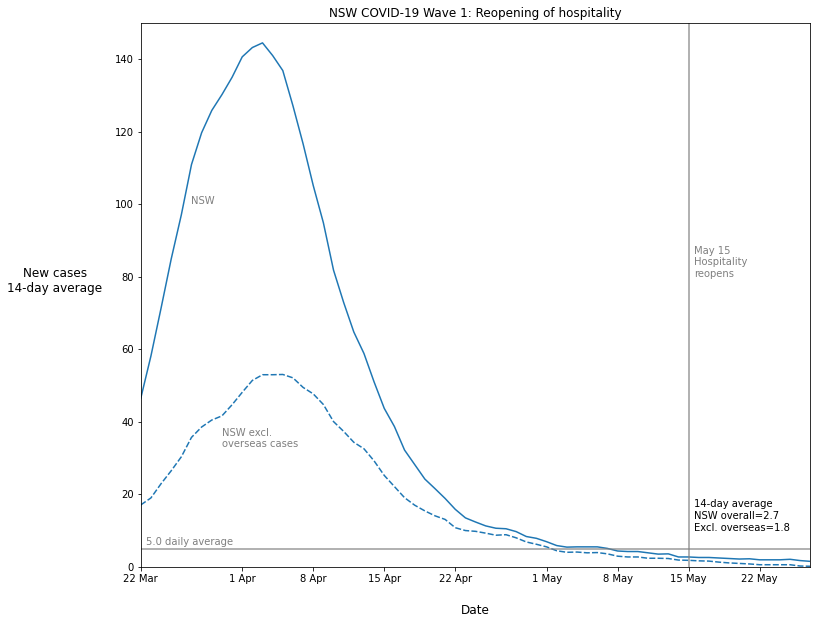

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

df_data_nsw_plot = df_data[df_data['province_name'].isin({'NSW', 'NSW - Wave 1 excluding overseas'})].sort_values(['province_name', 'date'])

xlim_values = (mdates.date2num(datetime(2020, 3, 22)), mdates.date2num(datetime(2020, 5, 27)))
ylim_values = (0, 150)

sns.lineplot(x='date', 
             y='new_cases_moving_avg', 
             style='province_name', 
             data=df_data_nsw_plot)
ax.plot([mdates.date2num(datetime(2020, 5, 15))]*2, ylim_values, color=(0.5, 0.5, 0.5), alpha=0.8)
ax.plot(xlim_values, [5.0]*2, color=(0.5, 0.5, 0.5), alpha=0.8)
ax.set_xlim(xlim_values)
ax.set_ylim(ylim_values)
ax.get_legend().remove()
ax.set_ylabel('New cases\n14-day average', rotation=0, fontsize=12, labelpad=60)
ax.set_xlabel('Date', fontsize=12, labelpad=20)
ax.text(mdates.date2num(datetime(2020, 3, 30)), 33, 'NSW excl.\noverseas cases', alpha=0.5)
ax.text(mdates.date2num(datetime(2020, 3, 27)), 100, 'NSW', alpha=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b'))
ax.set_title('NSW COVID-19 Wave 1: Reopening of hospitality')
ax.text(mdates.date2num(datetime(2020, 5, 15))+0.5, 80, 'May 15\nHospitality\nreopens', alpha=0.5)
ax.text(mdates.date2num(datetime(2020, 3, 22))+0.5, 6, '5.0 daily average', alpha=0.5)
ax.text(mdates.date2num(datetime(2020, 5, 15))+0.5, 10, '14-day average\nNSW overall=2.7\nExcl. overseas=1.8')

print(df_data_nsw_plot[df_data_nsw_plot['date'] == datetime(2020, 5, 15)][['date', 'province_name', 'new_cases_moving_avg']])
print('\n\n')
plt.show()

In [142]:
df_data.to_csv('df_data_vic_nsw.csv', index=False)